In [1]:
!pip install pyvi


In [2]:
from google.colab import drive
import os
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pyvi.ViTokenizer import ViTokenizer
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Bidirectional, LSTM, GRU, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, SpatialDropout1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import text, sequence
from keras import backend as K
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
DIR_ROOT = '/content/gdrive/MyDrive/'
DIR_DATASET = os.path.join(DIR_ROOT, 'dataset')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')
PATH_TEST = os.path.join(DIR_DATASET, 'test.csv')
STOPWORDS_PATH = os.path.join(DIR_ROOT, 'vietnamese-stopwords-dash.txt')


In [6]:
data_train = pd.read_csv(PATH_TRAIN)
X_train = data_train.iloc[:, 0:2]
y_train = data_train.iloc[:, 2:4]

data_dev = pd.read_csv(PATH_DEV)
X_dev = data_dev.iloc[:, 0:2]
y_dev = data_dev.iloc[:, 2:4]


data_test = pd.read_csv(PATH_TEST)
X_test = data_test.iloc[:, 0:2]
y_test = data_test.iloc[:, 2:4]

In [7]:

with open(STOPWORDS_PATH, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [8]:

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text


def pre_process_features(X, y1, y2, tokenized = True, lowercased = True):
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            X = np.delete(X, idx)
            y1 = np.delete(y1, idx)
            y2 = np.delete(y2, idx)
    return X, y1, y2



In [9]:
train_X, train_y, train_y_spam = pre_process_features(X_train['Comment'], y_train['Label'], y_train['SpamLabel'], tokenized=True, lowercased = False)
dev_X, dev_y, dev_y_spam = pre_process_features(X_dev['Comment'], y_dev['Label'], y_dev['SpamLabel'], tokenized=True, lowercased = False)
test_X, test_y, test_y_spam = pre_process_features(X_test['Comment'], y_test['Label'], y_test['SpamLabel'], tokenized=True, lowercased = False)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

def tfidf_embedding(text):
  tfidf_vectorizer = TfidfVectorizer(max_features=7000)
  text = tfidf_vectorizer.fit_transform(text).toarray()
  return text

In [14]:
train_X = tfidf_embedding(train_X)
dev_X = tfidf_embedding(dev_X)
test_X = tfidf_embedding(test_X)

In [15]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(train_X,train_y)

MultinomialNB()

In [33]:
def show_predict_result(model, X_test, y_test, labels):
    y_pred = model.predict(X_test)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index = labels , columns = labels)
    sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))

F1 - micro: 0.4287153652392947
F1 - macro: 0.42243447899304554
Accuracy: 0.4287153652392947


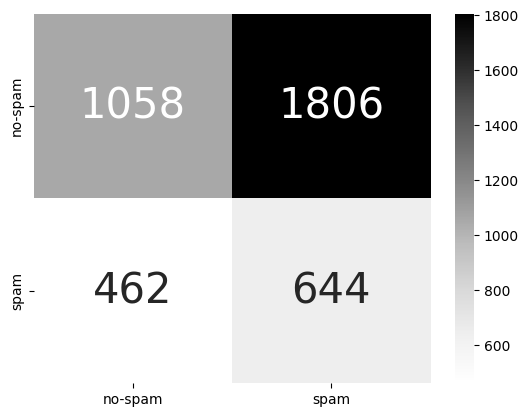

In [34]:
labels_task_1 = ["no-spam", "spam"]
show_predict_result(mnb, test_X, test_y, labels_task_1)

In [35]:
mnb = MultinomialNB()

mnb.fit(train_X,train_y_spam)



MultinomialNB()

F1 - micro: 0.3758186397984887
F1 - macro: 0.19016121266215752
Accuracy: 0.3758186397984887


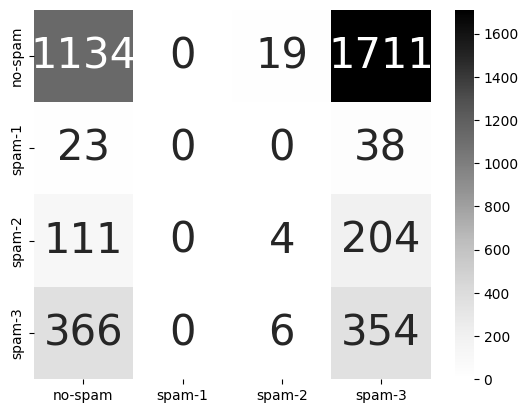

In [36]:
labels_task_2 = ["no-spam", "spam-1", "spam-2", "spam-3"]
show_predict_result(mnb, test_X, test_y_spam, labels_task_2)